In [12]:
import tensorflow as tf
import pydot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [13]:
file = open("metamorphosis_clean.txt", "r" , encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  

The Last Line:   



In [14]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

' One morning, when Gregor Samsa woke up from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on his armour-like back, and if he lifted his head a little he could   see his brown belly, slightly domed and divided by arches into stiff   sections.  The bedding was hardly able to cover it and seemed ready   to slide off an'

In [15]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

' One morning  when Gregor Samsa woke up from troubled dreams  he found himself transformed in his bed into a horrible vermin  He lay on his armour like back  and if he lifted his head a little he could   see his brown belly  slightly domed and divided by arches into stiff   sections   The bedding was hardly able to cover it and seemed ready   to slide off any moment   His many legs  pitifully thin compared   with the size of the rest of him  waved about helplessly as he   looked        What s ha'

In [16]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke up from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room al'

TOKENIZATION

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[17, 53, 293, 2, 18, 729, 54, 135, 730, 294]

In [18]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [19]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729,  54],
       [ 54, 135],
       [135, 730],
       [730, 294],
       [294,   8]])

In [20]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [21]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 17  53 293   2  18]
The responses are:  [ 53 293   2  18 729]


In [22]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

CREATING A MODEL

In [23]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             26170     
                                                                 
 lstm (LSTM)                 (None, 1, 1000)           4044000   
                                                                 
 lstm_1 (LSTM)               (None, 1000)              8004000   
                                                                 
 dense (Dense)               (None, 1000)              1001000   
                                                                 
 dense_1 (Dense)             (None, 2617)              2619617   
                                                                 
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


In [ ]:
PLOT THE MODEL

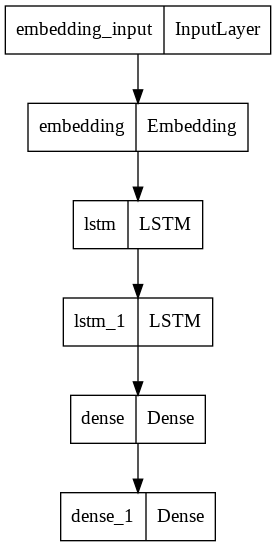

In [25]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

CALLBACKS

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

COMPILE THE MODEL

In [27]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


FIT THE MODEL

In [28]:
model.fit(X, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/150
61/61 [==============================] - ETA: 0s - loss: 7.8750
Epoch 1: loss improved from inf to 7.87502, saving model to nextword1.h5
61/61 [==============================] - 17s 213ms/step - loss: 7.8750 - lr: 0.0010
Epoch 2/150
61/61 [==============================] - ETA: 0s - loss: 7.8628
Epoch 2: loss improved from 7.87502 to 7.86277, saving model to nextword1.h5
61/61 [==============================] - 13s 211ms/step - loss: 7.8628 - lr: 0.0010
Epoch 3/150
61/61 [==============================] - ETA: 0s - loss: 7.8162
Epoch 3: loss improved from 7.86277 to 7.81623, saving model to nextword1.h5
61/61 [==============================] - 13s 210ms/step - loss: 7.8162 - lr: 0.0010
Epoch 4/150
61/61 [==============================] - ETA: 0s - loss: 7.6297
Epoch 4: loss improved from 7.81623 to 7.62965, saving model to nextword1.h5
61/61 [==============================] - 13s 210ms/step - loss: 7.6297 - lr: 0.0010
Epoch 5/150
61/61 [==============================] - ETA